# Atividade 03: Implementando uma Rede Neural Profunda

Nesta atividade, você irá treinar uma rede neural profunda para realizar classificação de imagens, e irá testá-la utilizando o dataset CIFAR-10.

Nesta atividade, você irá:

- testar implementação de **camada afim** (tranformação linear)
- testar implementação de **camada ReLU**
- testar implementação de camadas combinadas (Afim + ReLU)  
- testar duas **funções de perda** (**loss functions**): *SVM (hinge) loss* e *Softmax loss*
- testar a implementação modular de uma rede de duas camadas: `TwoLayerNet`
- testar a implementação modular de um classe para treinamento: `Solver`
- **treinar** o modelo de rede de duas camadas `TwoLayerNet` utilizando a classe `Solver` e visualizar os resultados de perda e acurácia do treinamento
- testar implementação de **batch normalization**
- testar implementação de **dropout**
- testar a implementação modular de uma rede profunda (de múltiplas camadas): `FullyConnectedNet`
- **treinar** o modelo de rede profunda `FullyConnectedNet` utilizando a classe `Solver` e diferentes regras de atualização
- **explorar o impacto** de *batch normalization* no treinamento de um modelo de rede profunda
- **explorar o impacto** de *dropout* no treinamento de um modelo de rede profunda


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("drive/My Drive/Pratica3")

Mounted at /content/drive/


## Código de inicialização e configuração básica


In [2]:
# Executa algum código de inicialização desse notebook.

from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # fixa tamanho default para as plotagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returna erro relativo """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Obtendo o conjunto de dados CIFAR-10


In [ ]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2024-06-20 20:34:38--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  34.2MB/s    in 5.1s    

2024-06-20 20:34:43 (32.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
# Carrega os dados brutos da base CIFAR-10.
# Para tanto, você deve ter feito o download de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# e descompactado no diretório 'cifar-10-batches-py'

from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ carrega um unico lote do dataset cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ carrega todo o dataset cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000,
                     subtract_mean=True):
    """
    Carrega o dataset CIFAR-10 a partir do disco e realiza pré-processamento para prepará-lo
    para uso com classificadores.
    """
    # Carrega dados brutos do dataset CIFAR-10
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subamostragem de dados
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalização de dados: subtração de imagem media
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transposição de modo que canais venham primeiro
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Empacota dados em um dicionario
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Camada Afim: *foward pass*



In [4]:
def affine_forward(x, w, b):
    """
    Computa o forward pass para uma camada afim.

    A entrada x possui dimensoes (N, d_1, ..., d_k) e comtem um minibatch de N
    amostras, em que cada amostra x[i] possui dimensoes (d_1, ..., d_k).
    Cada entrada será redimensionada em um vetor de dimensão D = d_1 * ... * d_k, e
    então este será transformado no vetor de saida de dimensão M.

    Entradas:
    - x: Um vetor numpy contendo dados de entrada, com dimensoes (N, d_1, ..., d_k)
    - w: Um vetor numpy de pesoes, com dimensoes (D, M)
    - b: Um vetor numpy de termos independentes (vieses), dimensão (M,)

    Retorna:
    - out: saida, com dimensoes (N, M)
    - cache: (x, w, b)
    """

    ###########################################################################
    xaux = np.reshape(x, (x.shape[0], -1))
    out = xaux.dot(w) + b
    ###########################################################################

    cache = (x, w, b)
    return out, cache


In [5]:
# Teste para a função affine_forward

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare seu resultado com o resultado correto que foi fornecido.
# O erro deve estar em cerca de 1e-9.
print('Testando a funcao affine_forward: ')
print('Diferença: ', rel_error(out, correct_out))

Testando a funcao affine_forward: 
Diferença:  9.769849468192957e-10


# Camada Afim: *backward pass*

In [6]:
def affine_backward(dout, cache):
    """
    Computa o backward pass para a camada afim.

    Entradas:
    - dout: Derivada "upstream", com dimensoes (N, M)
    - cache: (x, w, b):
      - x: Dados de entrada, com dimensoes (N, d_1, ... d_k)
      - w: Pesos, com dimensoes (D, M)
      - b: Termos independentes, com dimensao (M,)

    Retorna:
    - dx: Gradiente em relacao a x, com dimesoes (N, d1, ..., d_k)
    - dw: Gradiente em relacao a w, com dimesoes (D, M)
    - db: Gradiente em relacao a b, com dimesao (M,)
    """
    x, w, b = cache

    ###########################################################################
    dx = np.dot(dout, w.T).reshape(x.shape)
    dw = np.dot(x.reshape(x.shape[0], -1).T, dout)
    db = np.sum(dout, axis=0)
    ###########################################################################

    return dx, dw, db


In [7]:
from __future__ import print_function
from builtins import range
from past.builtins import xrange

import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    Uma implementacao simples de gradiente numérico de f em x
    - f deve ser uma funcao que recebe um unico argumento
    - x é um ponto (vetor numpy) onde sera avaliado o gradiente
    """

    fx = f(x) # avalia a funcao no ponto original
    grad = np.zeros_like(x)
    # realizar iteracoes sobre todos os indices/dimensoes de x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # avalia a funcao em x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # incrementa de h
        fxph = f(x) # avalia f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # avalia f(x - h)
        x[ix] = oldval # restaura

        # computa a derivada parcial por meio de diferenca central
        grad[ix] = (fxph - fxmh) / (2 * h)
        if verbose:
            print(ix, grad[ix])
        it.iternext() # passa para a proxima dimensao

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Avalia um gradiente numerico para uma funcao que aceita um vetor numpy
    como parametro e retorna um vetor numpy.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

# Teste para a função affine_backward
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# Os erros devem estar em torno de 1e-10
print('Testando a funcao affine_backward:')
print('Erro em dx: ', rel_error(dx_num, dx))
print('Erro em dw: ', rel_error(dw_num, dw))
print('Erro em db: ', rel_error(db_num, db))

Testando a funcao affine_backward:
Erro em dx:  5.399100368651805e-11
Erro em dw:  9.904211865398145e-11
Erro em db:  2.4122867568119087e-11


# Camada ReLU: *forward pass*

In [8]:
def relu_forward(x):
    """
    Computa o forward pass para uma camada de unidades lineares retificadas (ReLUs).

    Entrada:
    - x: Dados de entrada, qualquer dimensionalidade

    Returna:
    - out: Saida, com a mesma dimensionalidade de x
    - cache: x
    """

    ###########################################################################
    out = np.maximum(0,x)
    ###########################################################################

    cache = x
    return out, cache


In [9]:
# Teste para a função relu_forward

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare seu resultado com o resultado correto que foi fornecido.
# O erro deve estar em cerca de 5e-8.
print('Testando a funcao relu_forward:')
print('Diferença: ', rel_error(out, correct_out))

Testando a funcao relu_forward:
Diferença:  4.999999798022158e-08


# Camada ReLU: *backward pass*


In [10]:
def relu_backward(dout, cache):
    """
    Computa o backward pass para uma camada de unidades lineares retificadas (ReLUs).

    Entradas:
    - dout: Derivada "upstream", de qualquer dimensionalidade
    - cache: Entrada x, com a mesma dimensionalidade que  dout

    Returna:
    - dx: Gradiente em relacao a x
    """
    dx, x = None, cache

    ###########################################################################
    dx = np.array(dout, copy=True)
    dx[x <= 0] = 0
    ###########################################################################

    return dx


In [11]:
# Teste para a função relu_backward
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# O erro deve estar em torno de 3e-12
print('Testando a funcao relu_backward:')
print('Erro em dx: ', rel_error(dx_num, dx))

Testando a funcao relu_backward:
Erro em dx:  3.2756349136310288e-12


# "Sandwich" de Camadas

In [12]:
def affine_relu_forward(x, w, b):
    """
    Calcula o forward pass para a camada combinada que realiza uma transformacao afim seguida de ReLU

    Entradas:
    - x: Dados de entrada para a camada afim
    - w, b: Pesos/vieses para a camada afim

    Returna:
    - out: Saida final depois da camada ReLU
    - cache: Informacao necessaria para realizar o backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Calcula o backward pass para a camada combinada que realiza uma transformacao afim seguida de ReLU
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db


In [13]:
# Teste para as funções affine_relu_forward e affine_relu_backward

np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testando as funcoes affine_relu_forward e affine_relu_backward:')
print('Erro em dx: ', rel_error(dx_num, dx))
print('Erro em dw: ', rel_error(dw_num, dw))
print('Erro em db: ', rel_error(db_num, db))

Testando as funcoes affine_relu_forward e affine_relu_backward:
Erro em dx:  2.299579177309368e-11
Erro em dw:  8.162011105764925e-11
Erro em db:  7.826724021458994e-12


# Camadas de Perda: Softmax e SVM


In [14]:
def svm_loss(x, y):
    """
    Computa a perda e o gradiente usando a perda por articulacao (hinge loss ou SVM loss).

    Entradas:
    - x: Dados de entrada, dimensoes (N, C) em que x[i, j] representa o score para
      a i-esima entrada em relacao a j-esima classe .
    - y: Vetor de rotulos, dimensao (N,) em que y[i] representa o rotulo para x[i] e
      0 <= y[i] < C

    Returna:
    - loss: Escalar representado o valor da perda
    - dx: Gradiente da perda em relacao a x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computa a perda e o gradiente usando a perda softmax.

    Entradas:
    - x: Dados de entrada, dimensoes (N, C) em que x[i, j] representa o score para
      a i-esima entrada em relacao a j-esima classe .
    - y: Vetor de rotulos, dimensao (N,) em que y[i] representa o rotulo para x[i] e
      0 <= y[i] < C

    Returna:
    - loss: Escalar representado o valor da perda
    - dx: Gradiente da perda em relacao a x
    """
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx


In [15]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Teste da função svm_loss. A perda (loss) deve estar em cerda de 9 e 'dx error' em torno de 1e-9
print('Testando a funcao svm_loss:')
print('Perda: ', loss)
print('Erro em dx: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Teste da função softmax_loss. A perda (loss) deve estar em cerda de 2.3 e 'dx error' em torno
# de 1e-8
print('\nTestando a fucao softmax_loss:')
print('Perda: ', loss)
print('Erro em dx: ', rel_error(dx_num, dx))

Testando a funcao svm_loss:
Perda:  8.999602749096233
Erro em dx:  1.4021566006651672e-09

Testando a fucao softmax_loss:
Perda:  2.302545844500738
Erro em dx:  9.384673161989355e-09


# Rede de Duas Camadas

In [16]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################

        self.D = input_dim
        self.M = hidden_dim
        self.C = num_classes
        self.reg = reg

        w1 = weight_scale * np.random.randn(self.D, self.M)
        b1 = np.zeros(hidden_dim)
        w2 = weight_scale * np.random.randn(self.M, self.C)
        b2 = np.zeros(self.C)


        self.params.update({'W1': w1,
                            'W2': w2,
                            'b1': b1,
                            'b2': b2})

        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################

        W1, b1, W2, b2 = self.params['W1'], self.params[
            'b1'], self.params['W2'], self.params['b2']

        X = X.reshape(X.shape[0], self.D)
        # Forward into first layer
        hidden_layer, cache_hidden_layer = affine_relu_forward(X, W1, b1)
        # Forward into second layer
        scores, cache_scores = affine_forward(hidden_layer, W2, b2)

        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}

        ############################################################################
        data_loss, dscores = softmax_loss(scores, y)
        reg_loss = 0.5 * self.reg * np.sum(W1**2)
        reg_loss += 0.5 * self.reg * np.sum(W2**2)
        loss = data_loss + reg_loss

        # Backpropagaton
        grads = {}
        # Backprop into second layer
        dx1, dW2, db2 = affine_backward(dscores, cache_scores)
        dW2 += self.reg * W2

        # Backprop into first layer
        dx, dW1, db1 = affine_relu_backward(
            dx1, cache_hidden_layer)
        dW1 += self.reg * W1

        grads.update({'W1': dW1,
                      'b1': db1,
                      'W2': dW2,
                      'b2': db2})

        ############################################################################

        return loss, grads


In [ ]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Classe *Solver*



In [17]:
from __future__ import print_function, division
from future import standard_library
standard_library.install_aliases()
from builtins import range
from builtins import object
import os
import pickle as pickle

import numpy as np

class optim:

    def sgd(w, dw, config=None):
        """
        Performs vanilla stochastic gradient descent.

        config format:
        - learning_rate: Scalar learning rate.
        """
        if config is None: config = {}
        config.setdefault('learning_rate', 1e-2)

        w -= config['learning_rate'] * dw
        return w, config

    def sgd_momentum(w, dw, config=None):
        """
        Performs stochastic gradient descent with momentum.

        config format:
        - learning_rate: Scalar learning rate.
        - momentum: Scalar between 0 and 1 giving the momentum value.
          Setting momentum = 0 reduces to sgd.
        - velocity: A numpy array of the same shape as w and dw used to store a
          moving average of the gradients.
        """
        if config is None: config = {}
        config.setdefault('learning_rate', 1e-2)
        config.setdefault('momentum', 0.9)
        v = config.get('velocity', np.zeros_like(w))

        next_w = None
        ###########################################################################

        v = config['momentum'] * v - config['learning_rate'] * dw # integrate velocity
        next_w = w + v

        ###########################################################################
        config['velocity'] = v

        return next_w, config

    def rmsprop(x, dx, config=None):
        """
        Uses the RMSProp update rule, which uses a moving average of squared
        gradient values to set adaptive per-parameter learning rates.

        config format:
        - learning_rate: Scalar learning rate.
        - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
          gradient cache.
        - epsilon: Small scalar used for smoothing to avoid dividing by zero.
        - cache: Moving average of second moments of gradients.
        """
        if config is None: config = {}
        config.setdefault('learning_rate', 1e-2)
        config.setdefault('decay_rate', 0.99)
        config.setdefault('epsilon', 1e-8)
        config.setdefault('cache', np.zeros_like(x))

        next_x = None
        ###########################################################################

        cache, decay_rate, eps, learning_rate \
            = config['cache'], config['decay_rate'], \
              config['epsilon'], config['learning_rate']
        cache = decay_rate * cache + (1 - decay_rate) * dx**2
        next_x = -learning_rate * dx / (np.sqrt(cache) + eps) + x
        config['cache'] = cache

        ###########################################################################

        return next_x, config

    def adam(x, dx, config=None):
        """
        Uses the Adam update rule, which incorporates moving averages of both the
        gradient and its square and a bias correction term.

        config format:
        - learning_rate: Scalar learning rate.
        - beta1: Decay rate for moving average of first moment of gradient.
        - beta2: Decay rate for moving average of second moment of gradient.
        - epsilon: Small scalar used for smoothing to avoid dividing by zero.
        - m: Moving average of gradient.
        - v: Moving average of squared gradient.
        - t: Iteration number.
        """
        if config is None: config = {}
        config.setdefault('learning_rate', 1e-3)
        config.setdefault('beta1', 0.9)
        config.setdefault('beta2', 0.999)
        config.setdefault('epsilon', 1e-8)
        config.setdefault('m', np.zeros_like(x))
        config.setdefault('v', np.zeros_like(x))
        config.setdefault('t', 1)

        next_x = None
        ###########################################################################

        learning_rate, beta1, beta2, eps, m, v, t \
            = config['learning_rate'], config['beta1'], config['beta2'], \
              config['epsilon'], config['m'], config['v'], config['t']

        t += 1
        m = beta1 * m + (1 - beta1) * dx
        v = beta2 * v + (1 - beta2) * (dx**2)

        # bias correction:
        mb = m / (1 - beta1**t)
        vb = v / (1 - beta2**t)

        next_x = -learning_rate * mb / (np.sqrt(vb) + eps) + x

        config['m'], config['v'], config['t'] = m, v, t

        ###########################################################################

        return next_x, config


class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various optoins (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        self.num_train_samples = kwargs.pop('num_train_samples', 1000)
        self.num_val_samples = kwargs.pop('num_val_samples', None)

        self.checkpoint_name = kwargs.pop('checkpoint_name', None)
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    def _save_checkpoint(self):
        if self.checkpoint_name is None: return
        checkpoint = {
          'model': self.model,
          'update_rule': self.update_rule,
          'lr_decay': self.lr_decay,
          'optim_config': self.optim_config,
          'batch_size': self.batch_size,
          'num_train_samples': self.num_train_samples,
          'num_val_samples': self.num_val_samples,
          'epoch': self.epoch,
          'loss_history': self.loss_history,
          'train_acc_history': self.train_acc_history,
          'val_acc_history': self.val_acc_history,
        }
        filename = '%s_epoch_%d.pkl' % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(checkpoint, f)


    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = (t == 0)
            last_it = (t == num_iterations - 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train,
                    num_samples=self.num_train_samples)
                val_acc = self.check_accuracy(self.X_val, self.y_val,
                    num_samples=self.num_val_samples)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                           self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params


In [20]:
model = TwoLayerNet()
solver = None

model = TwoLayerNet(hidden_dim = 200, reg = 0.5)
solver = Solver(model, data, update_rule = 'sgd',
                optim_config = {
                    'learning_rate': 1e-3,},
                lr_decay = 0.95, num_epochs = 10, batch_size = 250,
                print_every = 100)

solver.train()

pass

(Iteration 1 / 1960) loss: 2.458440
(Epoch 0 / 10) train acc: 0.141000; val_acc: 0.137000
(Iteration 101 / 1960) loss: 1.899572
(Epoch 1 / 10) train acc: 0.436000; val_acc: 0.437000
(Iteration 201 / 1960) loss: 1.828579
(Iteration 301 / 1960) loss: 1.636030
(Epoch 2 / 10) train acc: 0.451000; val_acc: 0.475000
(Iteration 401 / 1960) loss: 1.720949
(Iteration 501 / 1960) loss: 1.692280
(Epoch 3 / 10) train acc: 0.523000; val_acc: 0.470000
(Iteration 601 / 1960) loss: 1.671181
(Iteration 701 / 1960) loss: 1.569038
(Epoch 4 / 10) train acc: 0.516000; val_acc: 0.480000
(Iteration 801 / 1960) loss: 1.528736
(Iteration 901 / 1960) loss: 1.495380
(Epoch 5 / 10) train acc: 0.539000; val_acc: 0.490000
(Iteration 1001 / 1960) loss: 1.360656
(Iteration 1101 / 1960) loss: 1.492053
(Epoch 6 / 10) train acc: 0.529000; val_acc: 0.500000
(Iteration 1201 / 1960) loss: 1.517431
(Iteration 1301 / 1960) loss: 1.447073
(Epoch 7 / 10) train acc: 0.568000; val_acc: 0.505000
(Iteration 1401 / 1960) loss: 1.45

Acurácia de 0.599
Validação de 0.521

## Visualizando Perda e Acurácia durante o Treinamento

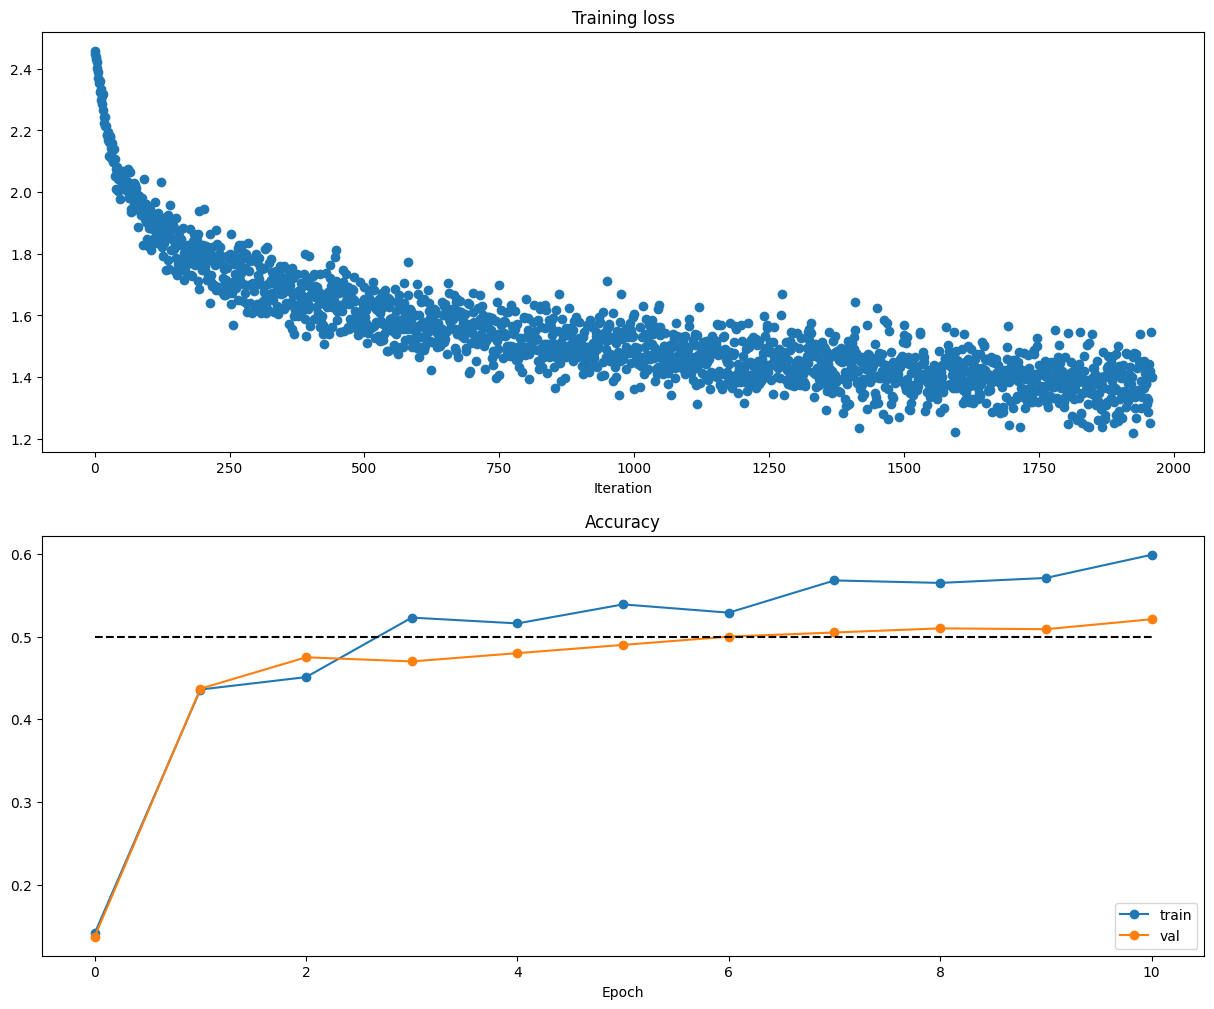

In [21]:
# Execute esta célula para visualizar a perda durante o treinamento e a acurácia
# tanto sobre o conjunto de treinamento quanto sobre o conjunto de validação.

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Batch Normalization

## Camada de *Batch Normalization*: *Forward pass*


In [22]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':

        #######################################################################
        # Forward pass
        # Step 1 - shape of mu (D,)
        mu = 1 / float(N) * np.sum(x, axis=0)

        # Step 2 - shape of var (N,D)
        xmu = x - mu

        # Step 3 - shape of carre (N,D)
        carre = xmu**2

        # Step 4 - shape of var (D,)
        var = 1 / float(N) * np.sum(carre, axis=0)

        # Step 5 - Shape sqrtvar (D,)
        sqrtvar = np.sqrt(var + eps)

        # Step 6 - Shape invvar (D,)
        invvar = 1. / sqrtvar

        # Step 7 - Shape va2 (N,D)
        va2 = xmu * invvar

        # Step 8 - Shape va3 (N,D)
        va3 = gamma * va2

        # Step 9 - Shape out (N,D)
        out = va3 + beta

        running_mean = momentum * running_mean + (1.0 - momentum) * mu
        running_var = momentum * running_var + (1.0 - momentum) * var

        cache = (mu, xmu, carre, var, sqrtvar, invvar,
                 va2, va3, gamma, beta, x, bn_param)

        #######################################################################

    elif mode == 'test':

        #######################################################################
        mu = running_mean
        var = running_var
        xhat = (x - mu) / np.sqrt(var + eps)
        out = gamma * xhat + beta
        cache = (mu, var, gamma, beta, bn_param)

        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache


In [23]:
# Checa o 'forward pass' durante o treinamento por meio da verificação de médias e variâncias
# das características tanto antes quanto depois da camada de 'batch normalization'

# Simula o 'forward pass' para uma rede de 2-camadas
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Médias devem estar próximas de zero e desvios padrões próximos de um
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Agora, médias devem estar próximas de 'beta' e desvios padrões próximos de 'gamma'
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]
After batch normalization (gamma=1, beta=0)
  mean:  [5.99520433e-17 7.16093851e-17 8.32667268e-19]
  std:  [0.99999999 1.         1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]


In [24]:
# Checa o 'forward pass' durante o teste por meio da execução do 'forward pass' em modo de
# treinamento por várias vezes de forma a obter médias móveis significativas (aquecimento);
# para, em seguida, checar as médias e variâncias das ativações após o 'forward pass' em modo
# de teste.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

# Realiza "aquecimento" para se obter médias móveis significativas
bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

# Altera para modo de teste de forma a utilizar as médias móveis obtidas anteriormente
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Médias devem estar próximas de zero e desvios padrões próximos de um,
# porém devem apresentar um 'ruído' maior que aquele observado durante o treinamento.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]


## Camada de *Batch Normalization*: *Backward pass*

In [25]:
def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################

    mu, xmu, carre, var, sqrtvar, invvar, va2, va3, gamma, beta, x, bn_param = cache
    eps = bn_param.get('eps', 1e-5)
    N, D = dout.shape

    # Backprop Step 9
    dva3 = dout
    dbeta = np.sum(dout, axis=0)

    # Backprop step 8
    dva2 = gamma * dva3
    dgamma = np.sum(va2 * dva3, axis=0)

    # Backprop step 7
    dxmu = invvar * dva2
    dinvvar = np.sum(xmu * dva2, axis=0)

    # Backprop step 6
    dsqrtvar = -1. / (sqrtvar**2) * dinvvar

    # Backprop step 5
    dvar = 0.5 * (var + eps)**(-0.5) * dsqrtvar

    # Backprop step 4
    dcarre = 1 / float(N) * np.ones((carre.shape)) * dvar

    # Backprop step 3
    dxmu += 2 * xmu * dcarre

    # Backprop step 2
    dx = dxmu
    dmu = - np.sum(dxmu, axis=0)

    # Basckprop step 1
    dx += 1 / float(N) * np.ones((dxmu.shape)) * dmu

    ###########################################################################

    return dx, dgamma, dbeta


In [26]:
# Verificação do 'backward pass' da camada de 'batch normalization'
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.6674604875341426e-09
dgamma error:  7.417225040694815e-13
dbeta error:  2.379446949959628e-12


# *Dropout*

## Camada de *Dropout*: *forward pass*

In [27]:
def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We drop each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':

        #######################################################################

        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask

        #######################################################################

    elif mode == 'test':

        #######################################################################

        out = x

        #######################################################################

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache



In [28]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.3
Mean of input:  10.000207878477502
Mean of train-time output:  10.035072797050494
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.699124
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.000207878477502
Mean of train-time output:  9.976910758765856
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.401368
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.000207878477502
Mean of train-time output:  9.993068588261146
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.250496
Fraction of test-time output set to zero:  0.0



## Camada de *Dropout*: *backward pass*

In [29]:
def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
        #######################################################################

        dx = dout * mask

        #######################################################################
    elif mode == 'test':

        dx = dout

    return dx


In [30]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445612718272284e-11


# Redes Multicamadas

In [31]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 dropout=0, use_batchnorm=False, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
          the network should not use dropout at all.
        - use_batchnorm: Whether or not the network should use batch normalization.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.use_batchnorm = use_batchnorm
        self.use_dropout = dropout > 0
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        if type(hidden_dims) != list:
            raise ValueError('hidden_dim has to be a list')

        self.L = len(hidden_dims) + 1
        self.N = input_dim
        self.C = num_classes
        dims = [self.N] + hidden_dims + [self.C]
        Ws = {'W' + str(i + 1):
              weight_scale * np.random.randn(dims[i], dims[i + 1]) for i in range(len(dims) - 1)}
        b = {'b' + str(i + 1): np.zeros(dims[i + 1])
             for i in range(len(dims) - 1)}

        self.params.update(b)
        self.params.update(Ws)

        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.

        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
            if seed is not None:
                self.dropout_param['seed'] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.

        self.bn_params = []
        if self.use_batchnorm:
            # self.bn_params = [{'mode': 'train'} for i in range(self.num_layers - 1)]
            print('We use batchnorm here')
            self.bn_params = {'bn_param' + str(i + 1): {'mode': 'train',
                                                        'running_mean': np.zeros(dims[i + 1]),
                                                        'running_var': np.zeros(dims[i + 1])}
                              for i in iter(range(len(dims) - 2))}
            gammas = {'gamma' + str(i + 1):
                      np.ones(dims[i + 1]) for i in range(len(dims) - 2)}
            betas = {'beta' + str(i + 1): np.zeros(dims[i + 1])
                     for i in range(len(dims) - 2)}

            self.params.update(betas)
            self.params.update(gammas)

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param['mode'] = mode
        if self.use_batchnorm:
            for key, bn_param in self.bn_params.items():
                bn_param[mode] = mode

        scores = None

        ############################################################################
        # We are gonna store everythin in a dictionnary hidden

        hidden = {}
        hidden['h0'] = X.reshape(X.shape[0], np.prod(X.shape[1:]))
        if self.use_dropout:
            # dropout on the input layer
            hdrop, cache_hdrop = dropout_forward(
                hidden['h0'], self.dropout_param)
            hidden['hdrop0'], hidden['cache_hdrop0'] = hdrop, cache_hdrop

        for i in range(self.L):
            idx = i + 1
            # Naming of the variable
            w = self.params['W' + str(idx)]
            b = self.params['b' + str(idx)]
            h = hidden['h' + str(idx - 1)]
            if self.use_dropout:
                h = hidden['hdrop' + str(idx - 1)]
            if self.use_batchnorm and idx != self.L:
                gamma = self.params['gamma' + str(idx)]
                beta = self.params['beta' + str(idx)]
                bn_param = self.bn_params['bn_param' + str(idx)]

            # Computing of the forward pass.
            # Special case of the last layer (output)

            if idx == self.L:
                h, cache_h = affine_forward(h, w, b)
                hidden['h' + str(idx)] = h
                hidden['cache_h' + str(idx)] = cache_h

            # For all other layers
            else:
                if self.use_batchnorm:
                    h, cache_h = affine_norm_relu_forward(
                        h, w, b, gamma, beta, bn_param)
                    hidden['h' + str(idx)] = h
                    hidden['cache_h' + str(idx)] = cache_h
                else:
                    h, cache_h = affine_relu_forward(h, w, b)
                    hidden['h' + str(idx)] = h
                    hidden['cache_h' + str(idx)] = cache_h

                if self.use_dropout:
                    h = hidden['h' + str(idx)]
                    hdrop, cache_hdrop = dropout_forward(h, self.dropout_param)
                    hidden['hdrop' + str(idx)] = hdrop
                    hidden['cache_hdrop' + str(idx)] = cache_hdrop

        scores = hidden['h' + str(self.L)]

        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}

        ############################################################################
        # Computing of the loss
        data_loss, dscores = softmax_loss(scores, y)
        reg_loss = 0
        for w in [self.params[f] for f in self.params.keys() if f[0] == 'W']:
            reg_loss += 0.5 * self.reg * np.sum(w * w)

        loss = data_loss + reg_loss

        # Backward pass

        hidden['dh' + str(self.L)] = dscores
        for i in range(self.L)[::-1]:
            idx = i + 1
            dh = hidden['dh' + str(idx)]
            h_cache = hidden['cache_h' + str(idx)]
            if idx == self.L:
                dh, dw, db = affine_backward(dh, h_cache)
                hidden['dh' + str(idx - 1)] = dh
                hidden['dW' + str(idx)] = dw
                hidden['db' + str(idx)] = db

            else:
                if self.use_dropout:
                    # First backprop in the dropout layer
                    cache_hdrop = hidden['cache_hdrop' + str(idx)]
                    dh = dropout_backward(dh, cache_hdrop)
                if self.use_batchnorm:
                    dh, dw, db, dgamma, dbeta = affine_norm_relu_backward(
                        dh, h_cache)
                    hidden['dh' + str(idx - 1)] = dh
                    hidden['dW' + str(idx)] = dw
                    hidden['db' + str(idx)] = db
                    hidden['dgamma' + str(idx)] = dgamma
                    hidden['dbeta' + str(idx)] = dbeta
                else:
                    dh, dw, db = affine_relu_backward(dh, h_cache)
                    hidden['dh' + str(idx - 1)] = dh
                    hidden['dW' + str(idx)] = dw
                    hidden['db' + str(idx)] = db

        # w gradients where we add the regulariation term
        list_dw = {key[1:]: val + self.reg * self.params[key[1:]]
                   for key, val in hidden.items() if key[:2] == 'dW'}
        # Paramerters b
        list_db = {key[1:]: val for key, val in hidden.items() if key[:2] ==
                   'db'}
        # Parameters gamma
        list_dgamma = {key[1:]: val for key, val in hidden.items() if key[
            :6] == 'dgamma'}
        # Paramters beta
        list_dbeta = {key[1:]: val for key, val in hidden.items() if key[
            :5] == 'dbeta'}

        grads = {}
        grads.update(list_dw)
        grads.update(list_db)
        grads.update(list_dgamma)
        grads.update(list_dbeta)

        ############################################################################

        return loss, grads

# Auxiliary function


def affine_norm_relu_forward(x, w, b, gamma, beta, bn_param):
    """
    Convenience layer that perorms an affine transform followed by a ReLU
    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer
    - gamma, beta : Weight for the batch norm regularization
    - bn_params : Contain variable use to batch norml, running_mean and var
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """

    h, h_cache = affine_forward(x, w, b)
    hnorm, hnorm_cache = batchnorm_forward(h, gamma, beta, bn_param)
    hnormrelu, relu_cache = relu_forward(hnorm)
    cache = (h_cache, hnorm_cache, relu_cache)

    return hnormrelu, cache


def affine_norm_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    h_cache, hnorm_cache, relu_cache = cache

    dhnormrelu = relu_backward(dout, relu_cache)
    dhnorm, dgamma, dbeta = batchnorm_backward(dhnormrelu, hnorm_cache)
    dx, dw, db = affine_backward(dhnorm, h_cache)

    return dx, dw, db, dgamma, dbeta


## Perda Inicial e Verificação de Gradiente

In [32]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.14e-08
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


(Iteration 1 / 40) loss: 44.720838
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.120000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.120000
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.132000
(Epoch 3 / 20) train acc: 0.580000; val_acc: 0.151000
(Epoch 4 / 20) train acc: 0.580000; val_acc: 0.166000
(Epoch 5 / 20) train acc: 0.800000; val_acc: 0.171000
(Iteration 11 / 40) loss: 1.046424
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.170000
(Epoch 7 / 20) train acc: 0.900000; val_acc: 0.165000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.161000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.160000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.160000
(Iteration 21 / 40) loss: 0.550636
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.154000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.155000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.157000
(Iteration 31 / 40) loss:

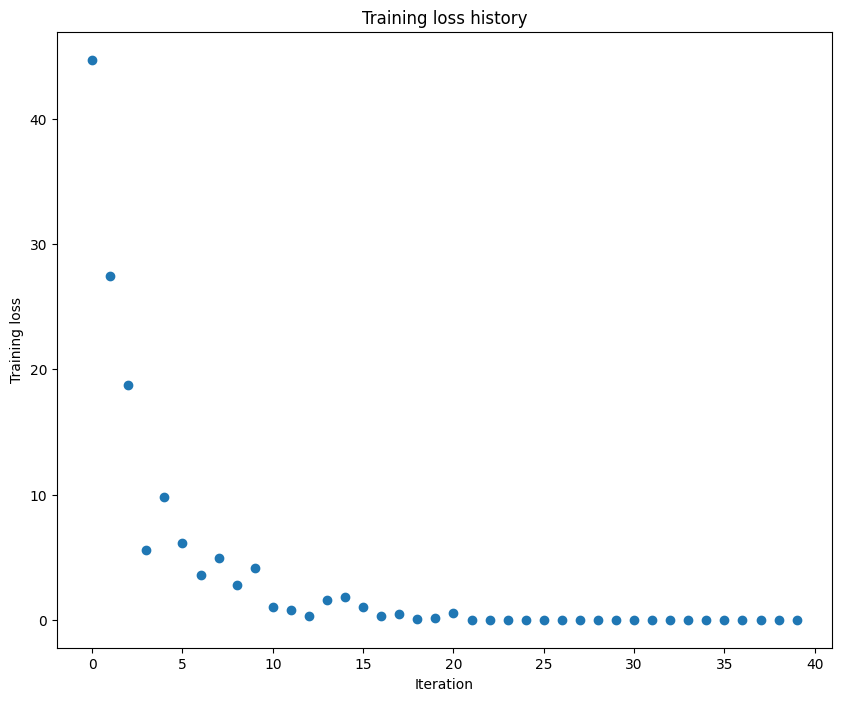

In [33]:
# TODO: Usar uma rede de 3-camadas para "sobreajustar" (overfit) 50 exemplos de treinamento.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

#weight_scale = 1e-2    # experimente variar entre 1e-2 e 5e-2
#learning_rate = 1e-4   # experimente variar entre 1e-4 e 5e-4
weight_scale = 5e-2
learning_rate = 5e-4

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 40) loss: 127.156652
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.111000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.117000
(Epoch 2 / 20) train acc: 0.220000; val_acc: 0.111000
(Epoch 3 / 20) train acc: 0.680000; val_acc: 0.109000
(Epoch 4 / 20) train acc: 0.920000; val_acc: 0.129000
(Epoch 5 / 20) train acc: 0.940000; val_acc: 0.129000
(Iteration 11 / 40) loss: 0.002608
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.108000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.116000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.122000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.123000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.123000
(Iteration 21 / 40) loss: 0.006845
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.125000
(Iteration 31 / 40) loss

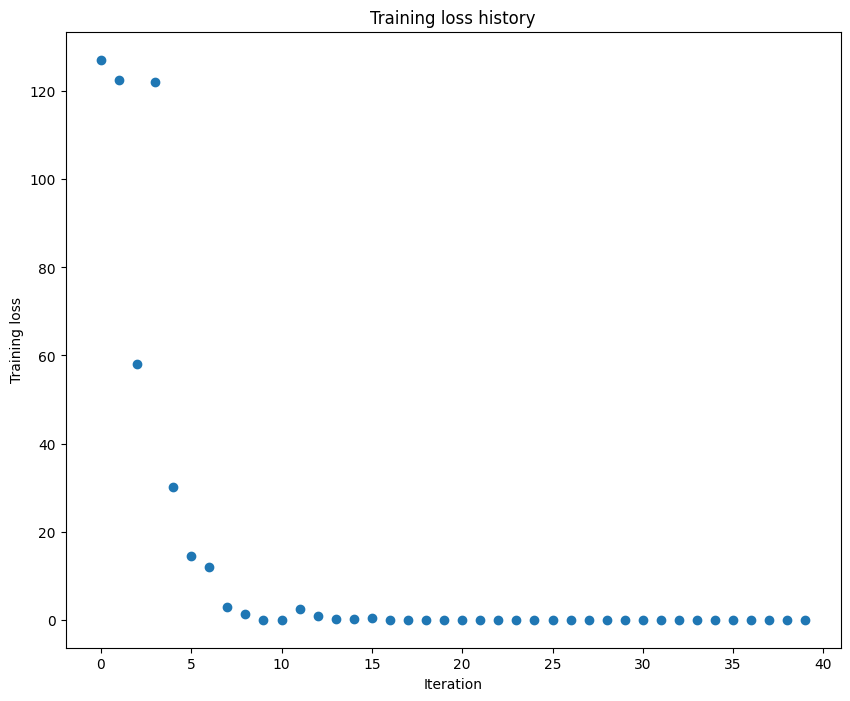

In [35]:
# TODO: Usar uma rede de 5-camadas para "sobreajustar" (overfit) 50 exemplos de treinamento.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

#weight_scale = 1e-2    # experimente variar entre 1e-2 e 1e-1
#learning_rate = 1e-5   # experimente variar entre 1e-5 e 1e-3
weight_scale = 1e-1
learning_rate = 1e-3

model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Regras de Atualização

## Regra de Atualização: SGD + Momento

In [36]:
# Teste da implementação de SGD+momento; você deve observar erros menores que 1e-8

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = optim.sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


running with  sgd
(Iteration 1 / 200) loss: 2.748818
(Epoch 0 / 5) train acc: 0.115000; val_acc: 0.104000
(Iteration 11 / 200) loss: 2.329576
(Iteration 21 / 200) loss: 2.101863
(Iteration 31 / 200) loss: 2.038474
(Epoch 1 / 5) train acc: 0.218000; val_acc: 0.221000
(Iteration 41 / 200) loss: 1.993958
(Iteration 51 / 200) loss: 1.980024
(Iteration 61 / 200) loss: 1.913175
(Iteration 71 / 200) loss: 1.926949
(Epoch 2 / 5) train acc: 0.343000; val_acc: 0.276000
(Iteration 81 / 200) loss: 1.933667
(Iteration 91 / 200) loss: 1.936248
(Iteration 101 / 200) loss: 1.827204
(Iteration 111 / 200) loss: 1.774129
(Epoch 3 / 5) train acc: 0.364000; val_acc: 0.312000
(Iteration 121 / 200) loss: 1.783914
(Iteration 131 / 200) loss: 1.744852
(Iteration 141 / 200) loss: 1.703779
(Iteration 151 / 200) loss: 1.779384
(Epoch 4 / 5) train acc: 0.375000; val_acc: 0.300000
(Iteration 161 / 200) loss: 1.815995
(Iteration 171 / 200) loss: 1.736792
(Iteration 181 / 200) loss: 1.663258
(Iteration 191 / 200) los

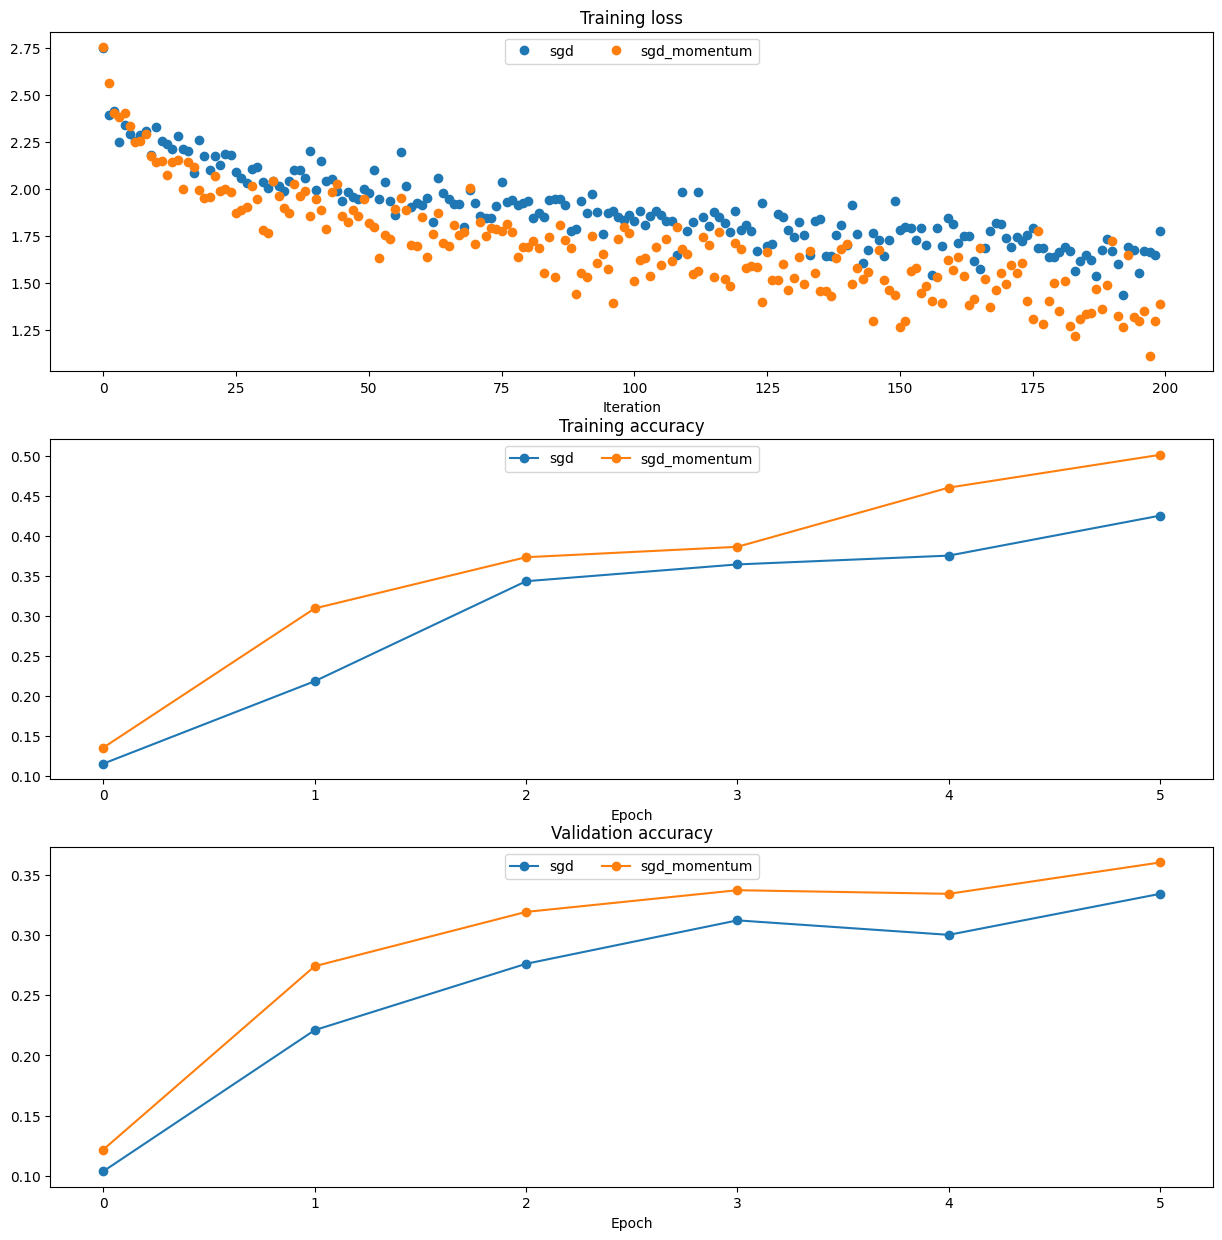

In [37]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)

  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Outras Regras de Atualização: RMSProp e Adam

In [38]:
# Teste da implementação de RMSProp; você deve observar erros menores que 1e-7

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = optim.rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [ ]:
# Teste da implementação de Adam; você deve observar erros em torno de 1e-7 ou menos

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = optim.adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

running with  adam
(Iteration 1 / 200) loss: 2.566155
(Epoch 0 / 5) train acc: 0.160000; val_acc: 0.136000
(Iteration 11 / 200) loss: 2.132931
(Iteration 21 / 200) loss: 2.172711
(Iteration 31 / 200) loss: 1.831773
(Epoch 1 / 5) train acc: 0.344000; val_acc: 0.312000
(Iteration 41 / 200) loss: 1.792316
(Iteration 51 / 200) loss: 1.892184
(Iteration 61 / 200) loss: 1.897166
(Iteration 71 / 200) loss: 1.686339
(Epoch 2 / 5) train acc: 0.412000; val_acc: 0.355000
(Iteration 81 / 200) loss: 1.493544
(Iteration 91 / 200) loss: 1.535971
(Iteration 101 / 200) loss: 1.531091
(Iteration 111 / 200) loss: 1.466455
(Epoch 3 / 5) train acc: 0.437000; val_acc: 0.365000
(Iteration 121 / 200) loss: 1.628168
(Iteration 131 / 200) loss: 1.409327
(Iteration 141 / 200) loss: 1.430260
(Iteration 151 / 200) loss: 1.305723
(Epoch 4 / 5) train acc: 0.538000; val_acc: 0.395000
(Iteration 161 / 200) loss: 1.305985
(Iteration 171 / 200) loss: 1.290688
(Iteration 181 / 200) loss: 1.378208
(Iteration 191 / 200) lo

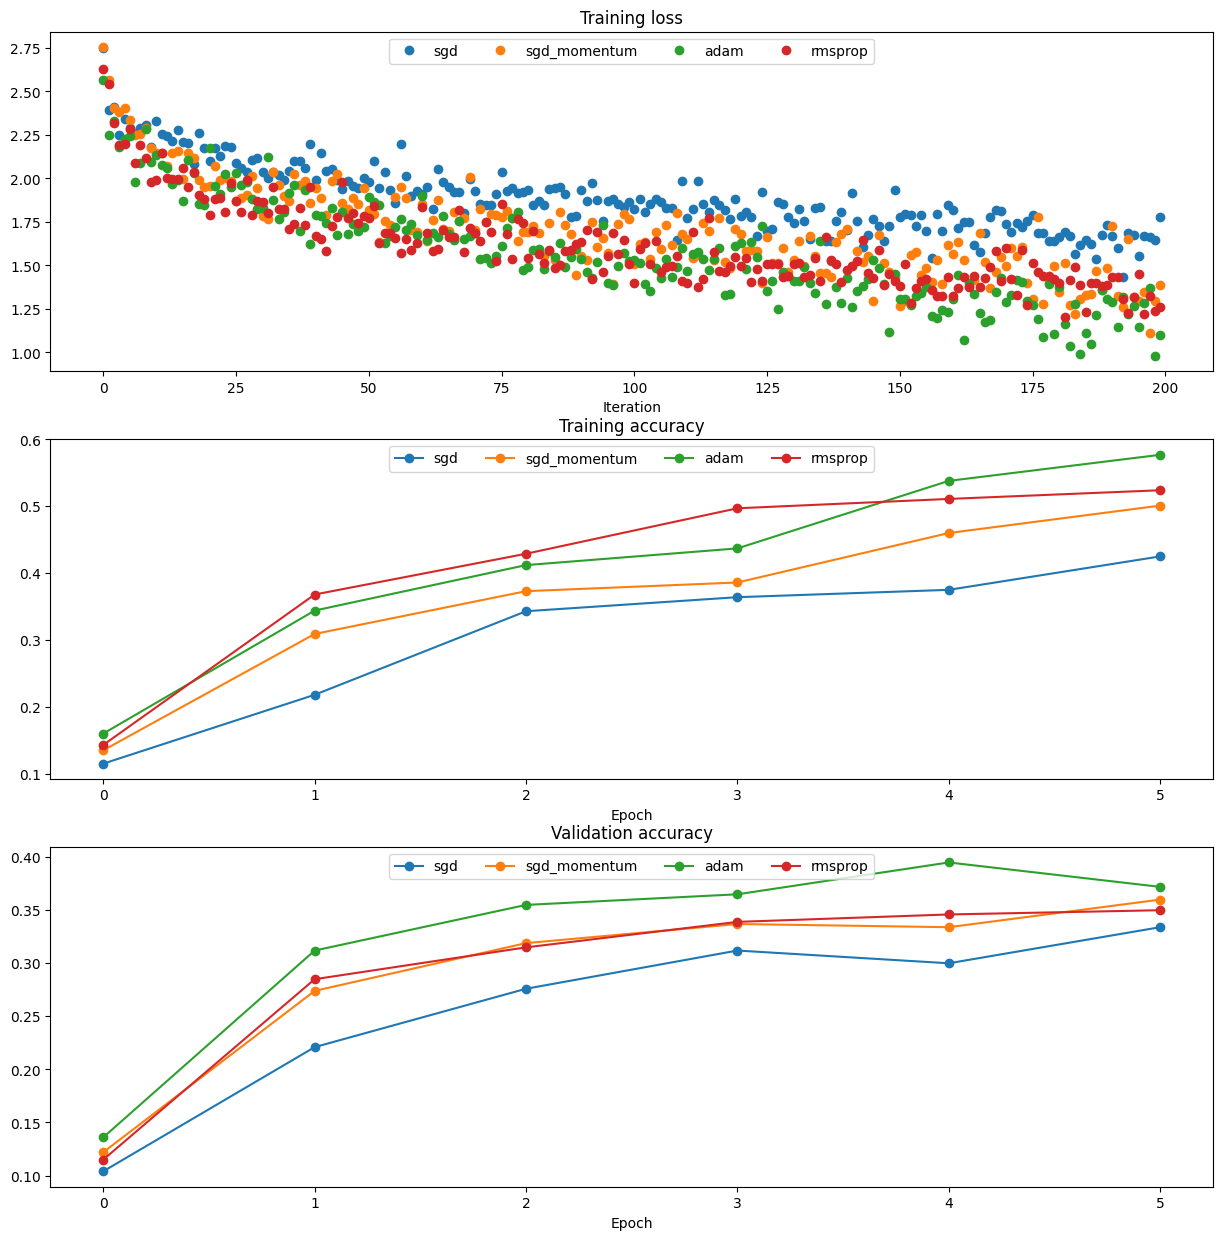

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)

  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# *Batch normalization* para Redes Profundas

In [39]:
np.random.seed(231)
# Tentativa de treinamento de uma rede profunda com e sem 'batch normalization'
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

We use batchnorm here
(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.132000; val_acc: 0.121000
(Epoch 1 / 10) train acc: 0.332000; val_acc: 0.277000
(Epoch 2 / 10) train acc: 0.432000; val_acc: 0.310000
(Epoch 3 / 10) train acc: 0.481000; val_acc: 0.316000
(Epoch 4 / 10) train acc: 0.554000; val_acc: 0.321000
(Epoch 5 / 10) train acc: 0.600000; val_acc: 0.336000
(Epoch 6 / 10) train acc: 0.630000; val_acc: 0.339000
(Epoch 7 / 10) train acc: 0.681000; val_acc: 0.338000
(Epoch 8 / 10) train acc: 0.712000; val_acc: 0.339000
(Epoch 9 / 10) train acc: 0.759000; val_acc: 0.348000
(Epoch 10 / 10) train acc: 0.749000; val_acc: 0.335000
(Iteration 1 / 200) loss: 2.302332
(Epoch 0 / 10) train acc: 0.123000; val_acc: 0.130000
(Epoch 1 / 10) train acc: 0.264000; val_acc: 0.212000
(Epoch 2 / 10) train acc: 0.320000; val_acc: 0.298000
(Epoch 3 / 10) train acc: 0.343000; val_acc: 0.275000
(Epoch 4 / 10) train acc: 0.397000; val_acc: 0.318000
(Epoch 5 / 10) train acc: 0.445000; val_acc

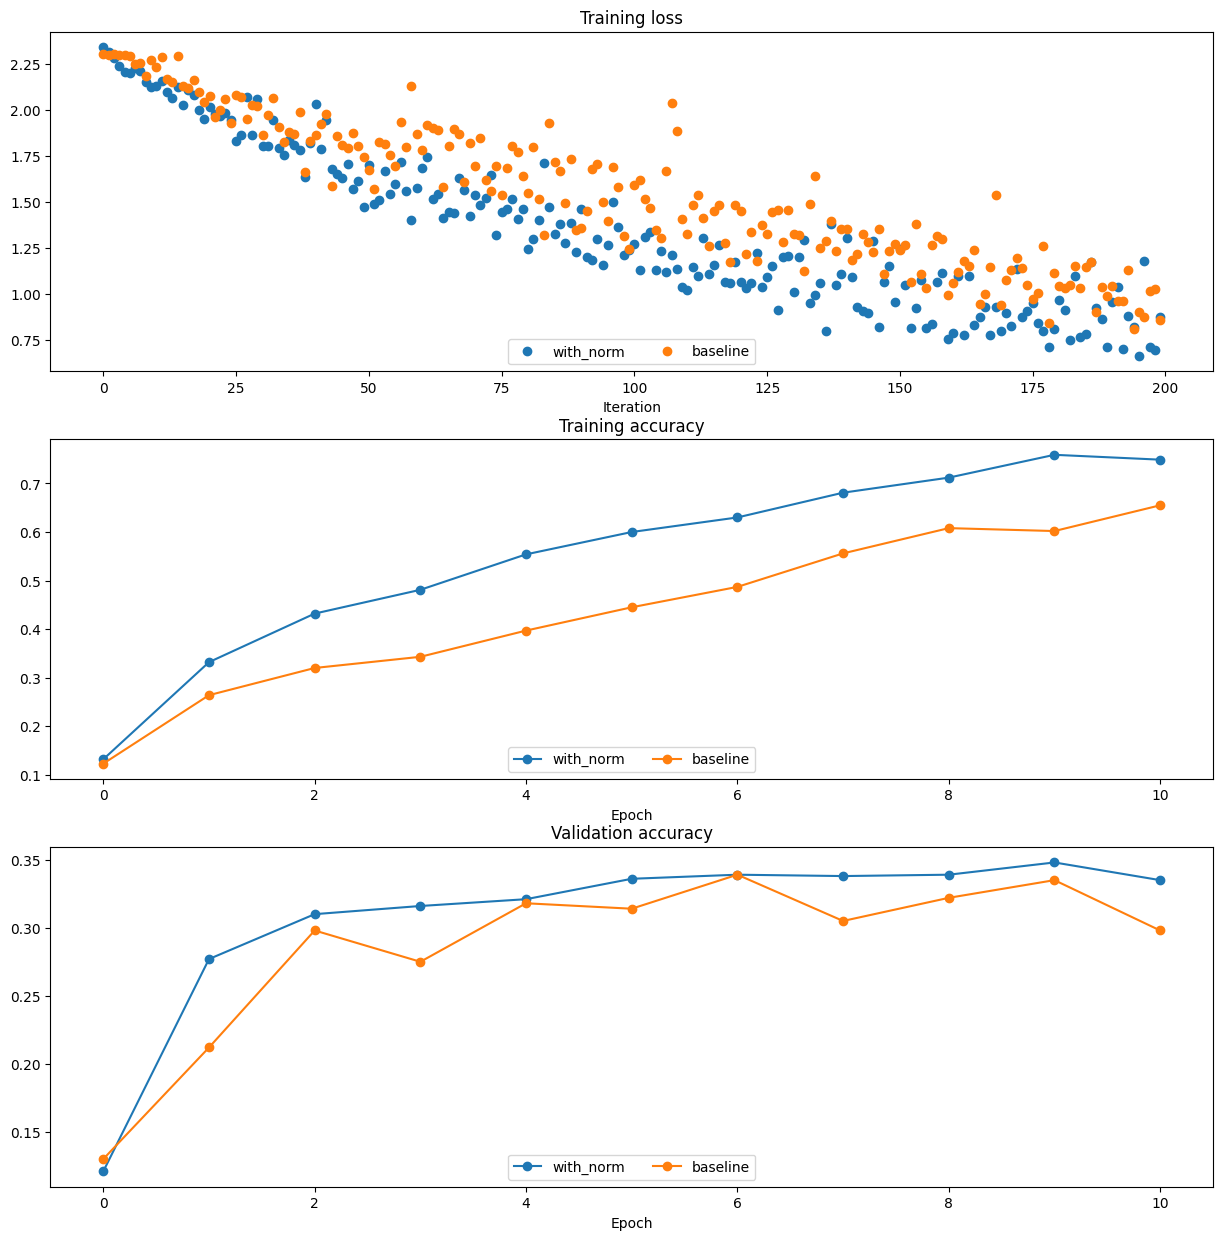

In [40]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1)


plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# *Batch normalization* e inicialização

In [41]:
np.random.seed(231)
# Tentativa de treinamento de uma rede 'bem' profunda com e sem 'batch normalization'
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
We use batchnorm here
Running weight scale 2 / 20
We use batchnorm here
Running weight scale 3 / 20
We use batchnorm here
Running weight scale 4 / 20
We use batchnorm here
Running weight scale 5 / 20
We use batchnorm here
Running weight scale 6 / 20
We use batchnorm here
Running weight scale 7 / 20
We use batchnorm here
Running weight scale 8 / 20
We use batchnorm here
Running weight scale 9 / 20
We use batchnorm here
Running weight scale 10 / 20
We use batchnorm here
Running weight scale 11 / 20
We use batchnorm here
Running weight scale 12 / 20
We use batchnorm here
Running weight scale 13 / 20
We use batchnorm here
Running weight scale 14 / 20
We use batchnorm here
Running weight scale 15 / 20
We use batchnorm here
Running weight scale 16 / 20
We use batchnorm here
Running weight scale 17 / 20
We use batchnorm here
Running weight scale 18 / 20
We use batchnorm here
Running weight scale 19 / 20
We use batchnorm here
Running weight scale 20 / 20
We use batc

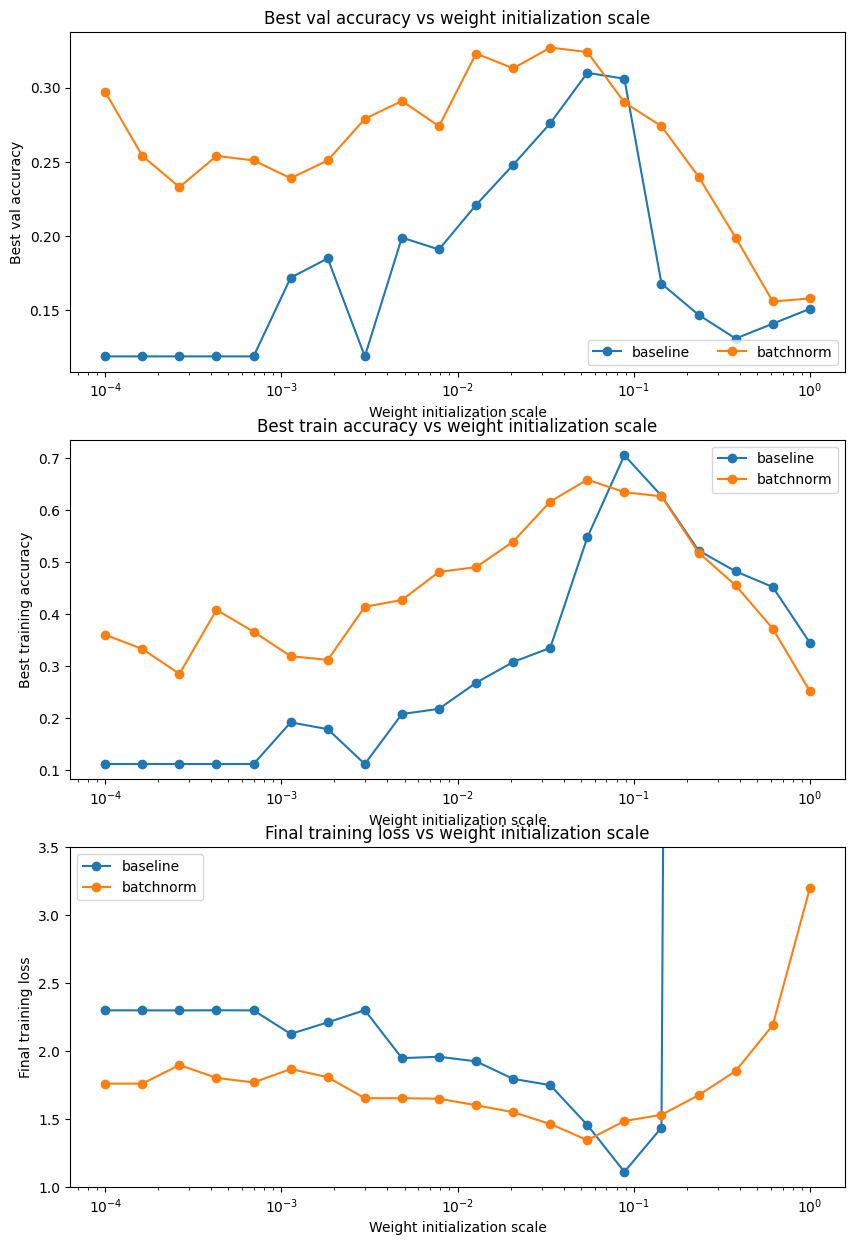

In [44]:
# 'Plota' gráficos dos resultados do experimento com diferentes escalas de iniciação de pesos.
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

  best_val_accs.append(max(solvers[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(10, 15)
plt.show()

# *Batch normalization* e tamanho do *minibatch*

In [45]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Tentativa de treinamento de uma rede 'bem' profunda com e sem 'batch normalization'
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()

    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)

    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
We use batchnorm here
Normalization: batch size =  10
We use batchnorm here
Normalization: batch size =  50
We use batchnorm here


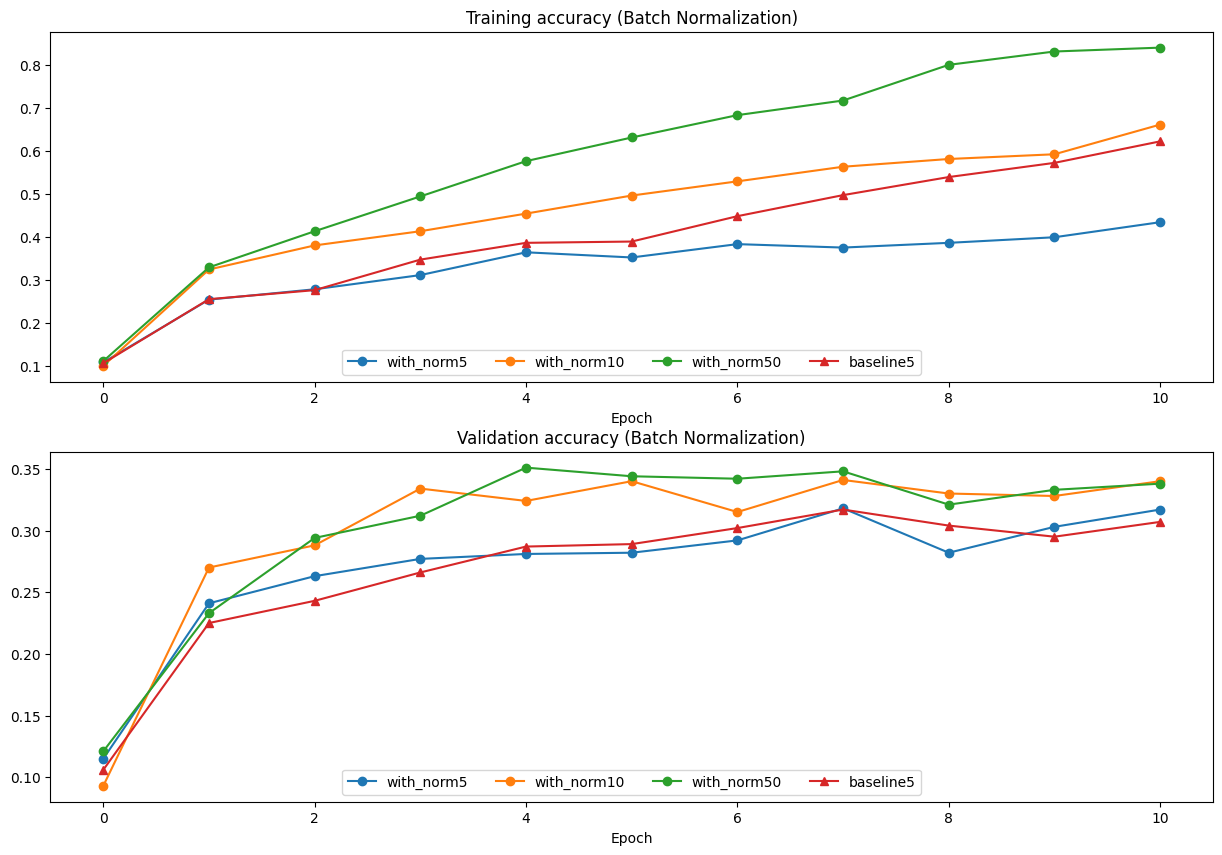

In [47]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

# Redes Completamente Conectadas com *Dropout*

In [46]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.25
Initial loss:  2.284540910068713
W1 relative error: 1.86e-10
W2 relative error: 1.60e-08
W3 relative error: 3.04e-09
b1 relative error: 1.10e-10
b2 relative error: 1.56e-08
b3 relative error: 8.58e-11

Running check with dropout =  0.5
Initial loss:  2.303349343266342
W1 relative error: 1.10e-08
W2 relative error: 1.92e-08
W3 relative error: 3.14e-08
b1 relative error: 5.52e-09
b2 relative error: 3.32e-09
b3 relative error: 1.40e-10



# Experimento de Regularização

In [48]:
# Treinar duas redes idênticas, uma com 'dropout e outra sem
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.274000; val_acc: 0.192000
(Epoch 1 / 25) train acc: 0.410000; val_acc: 0.263000
(Epoch 2 / 25) train acc: 0.518000; val_acc: 0.269000
(Epoch 3 / 25) train acc: 0.550000; val_acc: 0.248000
(Epoch 4 / 25) train acc: 0.684000; val_acc: 0.296000
(Epoch 5 / 25) train acc: 0.758000; val_acc: 0.292000
(Epoch 6 / 25) train acc: 0.782000; val_acc: 0.266000
(Epoch 7 / 25) train acc: 0.860000; val_acc: 0.241000
(Epoch 8 / 25) train acc: 0.868000; val_acc: 0.283000
(Epoch 9 / 25) train acc: 0.898000; val_acc: 0.281000
(Epoch 10 / 25) train acc: 0.896000; val_acc: 0.266000
(Epoch 11 / 25) train acc: 0.952000; val_acc: 0.289000
(Epoch 12 / 25) train acc: 0.958000; val_acc: 0.296000
(Epoch 13 / 25) train acc: 0.946000; val_acc: 0.279000
(Epoch 14 / 25) train acc: 0.976000; val_acc: 0.280000
(Epoch 15 / 25) train acc: 0.974000; val_acc: 0.293000
(Epoch 16 / 25) train acc: 0.984000; val_acc: 0.312000
(Epoch 17 / 25) train acc: 0.958000; v

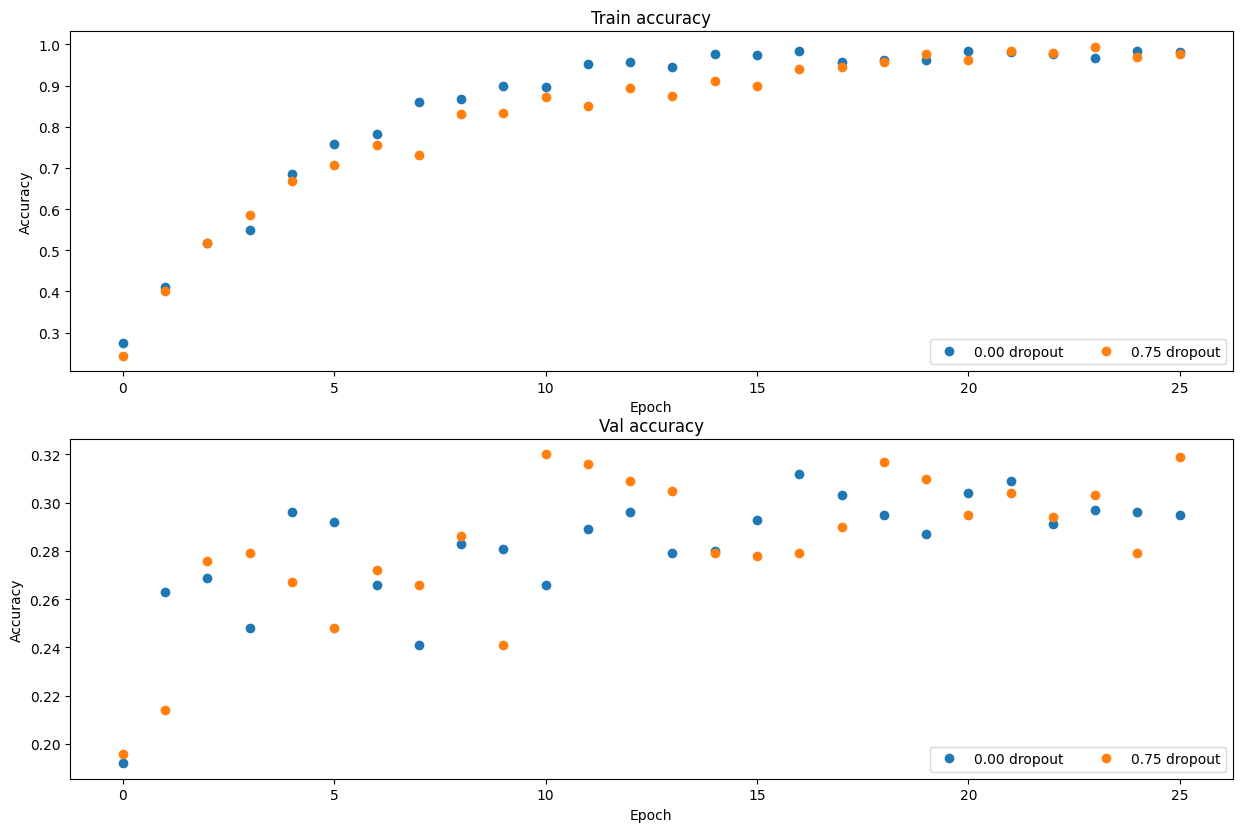

In [49]:
# 'Plota' acurácias de treinamento e validação para as duas redes

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Treinar um bom modelo!

Agora, você deverá treinar o melhor modelo (completamente conectado) que conseguir sobre a base de dados CIFAR-10, armazenando seu melhor modelo na variável `best_model`. Você deverá ser capar de obter pelo menos 50% de acurácia sobre o conjunto de validação utilizando uma rede completamente conectada.

Se você for cuidadoso, é possível se obter acurácias acima de 55%, porém isto não é necessário neste momento e você não receberá pontos extras se o fizer. Mais adiante, você será estimulado a treinar a melhor rede convolucional que conseguir sobre a bass de dados CIFAR-10 e, portanto, é melhor que você use seu esforços trabalhando com redes convolucionais do que com redes completamente conectadas.


In [62]:
best_model = None

# Definir os parâmetros do modelo
hidden_dims = [200, 200]  # Número de neurônios em cada camada oculta
num_classes = 10           # Número de classes no CIFAR-10
input_dim = 32 * 32 * 3    # Dimensão dos dados de entrada (imagens 32x32 RGB)

# Configuração dos hiperparâmetros
dropout = 0.5              # Probabilidade de dropout
use_batchnorm = True       # Utilizar batch normalization
reg = 1e-3                 # Termo de regularização L2
weight_scale = 1e-2        # Escala para inicialização dos pesos
dtype = np.float32         # Tipo de dados para os cálculos

# Inicializar o modelo
model = FullyConnectedNet(hidden_dims=hidden_dims,
                          input_dim=input_dim,
                          num_classes=num_classes,
                          dropout=dropout,
                          use_batchnorm=use_batchnorm,
                          reg=reg,
                          weight_scale=weight_scale,
                          dtype=dtype)

# Configuração do Solver
solver = Solver(model, data,
                num_epochs=25,
                batch_size=100,
                update_rule='adam',
                optim_config={
                    'learning_rate': 1e-4,
                },
                verbose=True, print_every=100)

# Treinar o modelo
solver.train()

We use batchnorm here
(Iteration 1 / 12250) loss: 2.360532
(Epoch 0 / 25) train acc: 0.116000; val_acc: 0.099000
(Iteration 101 / 12250) loss: 2.157012
(Iteration 201 / 12250) loss: 2.017718
(Iteration 301 / 12250) loss: 1.962804
(Iteration 401 / 12250) loss: 1.915328
(Epoch 1 / 25) train acc: 0.388000; val_acc: 0.380000
(Iteration 501 / 12250) loss: 1.842439
(Iteration 601 / 12250) loss: 1.804803
(Iteration 701 / 12250) loss: 1.849629
(Iteration 801 / 12250) loss: 1.816560
(Iteration 901 / 12250) loss: 1.725434
(Epoch 2 / 25) train acc: 0.431000; val_acc: 0.430000
(Iteration 1001 / 12250) loss: 1.841721
(Iteration 1101 / 12250) loss: 1.703405
(Iteration 1201 / 12250) loss: 1.686571
(Iteration 1301 / 12250) loss: 1.783721
(Iteration 1401 / 12250) loss: 1.697873
(Epoch 3 / 25) train acc: 0.453000; val_acc: 0.453000
(Iteration 1501 / 12250) loss: 1.714868
(Iteration 1601 / 12250) loss: 1.491489
(Iteration 1701 / 12250) loss: 1.525260
(Iteration 1801 / 12250) loss: 1.778872
(Iteration 190

In [63]:
# Avaliar o modelo no conjunto de teste
test_acc = solver.check_accuracy(data['X_test'], data['y_test'])
print('Acurácia no conjunto de teste: %.2f' % test_acc)

# Salvar o melhor modelo
best_model = model

Acurácia no conjunto de teste: 0.51


# Testar seu modelo

Executar o melhor modelo obtido anteriormente sobre os conjuntos de validação e de teste.
Você deve ter alcançado um resultado acima de 50% de acurácia sobre o conjunto de validação.

In [64]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.519
Test set accuracy:  0.509


#Salvando em pdf

In [66]:
!apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

done.


In [67]:
!jupyter nbconvert --to pdf "AtividadePratica3_ClaraCabralLisboa.ipynb"

[NbConvertApp] Converting notebook AtividadePratica3_ClaraCabralLisboa.ipynb to pdf
[NbConvertApp] Support files will be in AtividadePratica3_ClaraCabralLisboa_files/
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Making directory ./AtividadePratica3_ClaraCabralLisboa_files
[NbConvertApp] Writing 336646 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '